<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/paddlepaddle/paddledetection/PaddleDetection_and_W&B_Your_one_stop_for_everything_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{paddledetection} -->

<img src="https://user-images.githubusercontent.com/48054808/160532560-34cf7a1f-d950-435e-90d2-4b0a679e5119.png">

<!--- @wandbcode{paddledetection} -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

# Train and Debug your Object Detection Models with PaddleDetection and W&B 🪄🐝

PaddleDetection is an end-to-end object detection development kit based on PaddlePaddle, which implements varied mainstream object detection, instance segmentation, tracking and keypoint detection algorithms in modular design with configurable modules such as network components, data augmentations and losses.

This notebook will walk you through how to use the W&B integration in PaddleDetection to track your model training and save model checkpoints.

The W&B integration in PaddleDetection can be used in two ways
- Command Line 
```
python tools/train -c config.yml --use_wandb -o wandb-project=MyDetector wandb-entity=MyTeam wandb-save_dir=./logs
```
The arguments to the W&B logger must be proceeded by -o and each invidiual argument must contain the prefix "wandb-" and the `--use_wandb` flag should be used.
- YAML File: Add the arguments to the config.yml file under the wandb header like this
```
wandb:
    project: MyProject
    entity: MyTeam
    save_dir: ./logs
```

## Setup 🖥

We begin by installing the PaddlePaddle library followed by PaddleDetection

In [ ]:
%%shell
git clone https://github.com/PaddlePaddle/PaddleDetection
python -m pip install paddlepaddle-gpu==2.3.2.post112 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
pip install pyclipper attrdict gdown -qqq
cd PaddleDetection
git checkout develop
pip install -q -e .

In [ ]:
%cd PaddleDetection

Now we'll install and log into W&B.

In [ ]:
!pip install wandb -qU

In [ ]:

import wandb
wandb.login()

A few more imports and we are good to go!

In [ ]:
import os
import glob
import yaml

### Dataset 💿

We begin by downloading a [subset of the COCO 2017](https://wandb.ai/manan-goel/PaddleDetectionYOLOX/artifacts/dataset/COCOSubset/62e41eb3f1ebafcbd5a7) dataset created using this amazing [repository](https://github.com/giddyyupp/coco-minitrain/blob/master/src/sample_coco.py)

The dataset has been logged as a W&B artifact for easier downloading. It contains 1000 images for training and 250 for validation with corresponding annotations which we will now use for training our object detection model.

In [ ]:
artifact = wandb.Api().artifact("manan-goel/PaddleDetectionYOLOX/COCOSubset:latest")
path = artifact.download(root='./dataset/coco')

## Training 🏋️‍♀️

### Setting up the configuration 🛠

The configuration for the model is provided to the training script through yaml files in PaddleDetection so we're going to go ahead and edit it to suit our needs.

In [ ]:
with open("./configs/yolox/yolox_nano_300e_coco.yml", "r") as f:
    config = yaml.safe_load(f)


# Any arguments to wandb.init can be provided in the config['wandb'] dict

config['wandb'] = {
    'project': 'PaddleDetectionYOLOX'
}

config['log_iter'] = 1
config['snapshot_epoch'] = 5
config['epoch'] = 5
config['TrainReader']['batch_size'] = 32

with open("./configs/yolox/yolox_nano_300e_coco.yml", "w") as f:
    yaml.safe_dump(config, f)

### Training the Model 🏋️‍♀️

We now use the training script in the PaddleDetection library to train the YOLOX model and the config above adds W&B logging during training. We also add the `--eval` flag to have an evaluation step every 5 epochs since the validation set is extremely large.

In [ ]:
!python tools/train.py -c configs/yolox/yolox_nano_300e_coco.yml --eval

### Visualization

During training the metrics on the training and validation sets are logged to a W&B dashboard which looks something like this

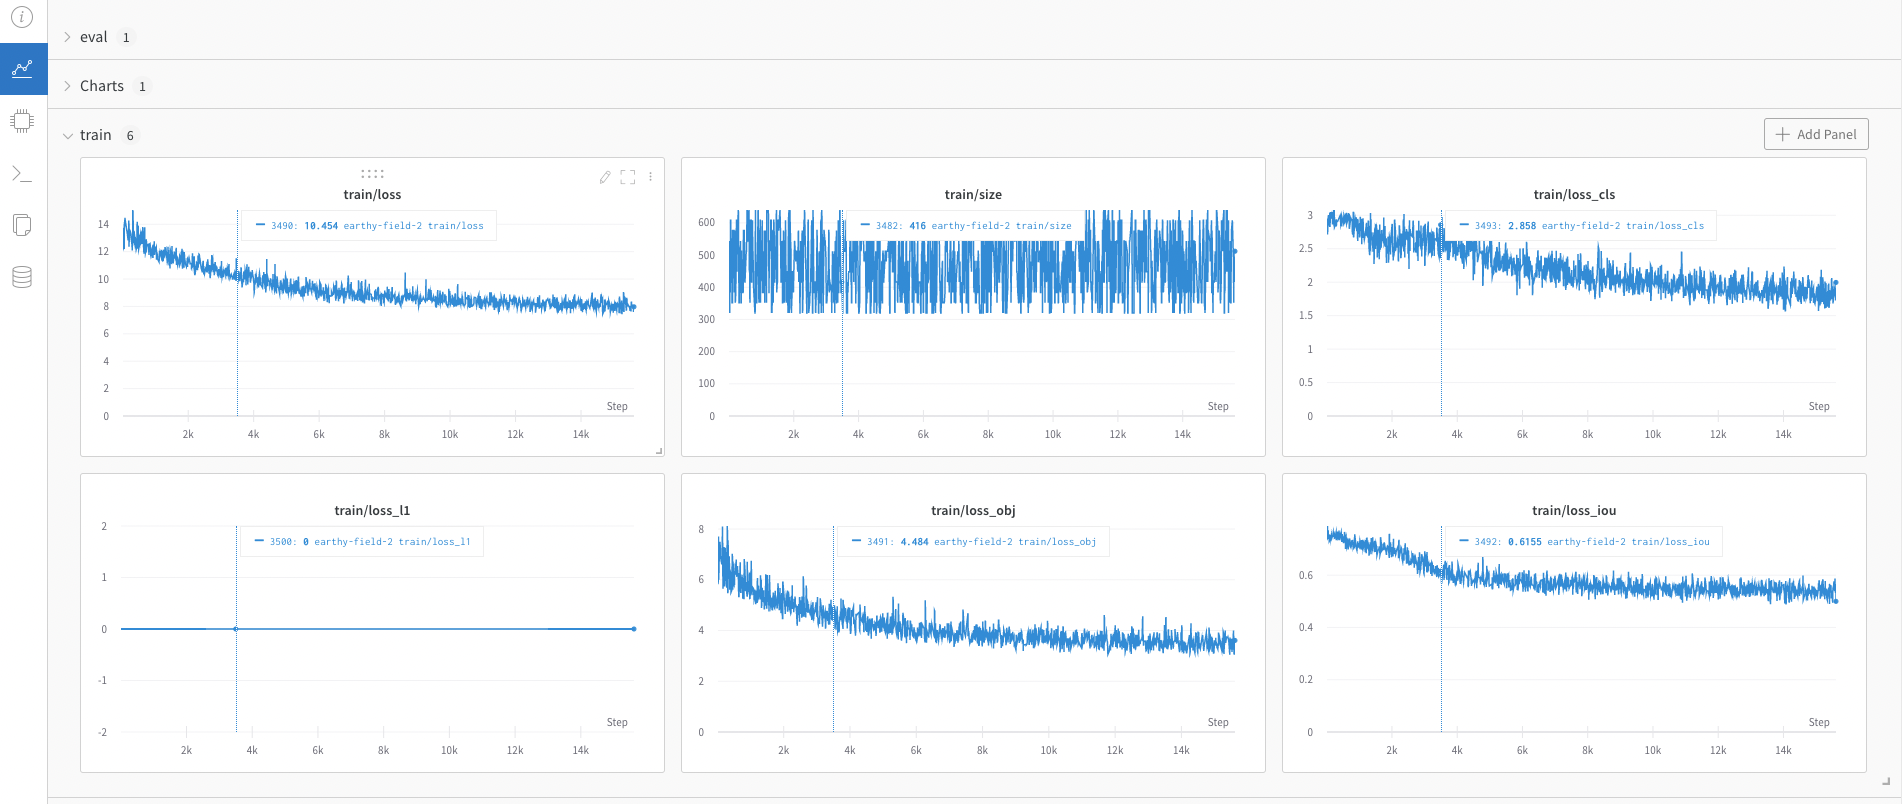

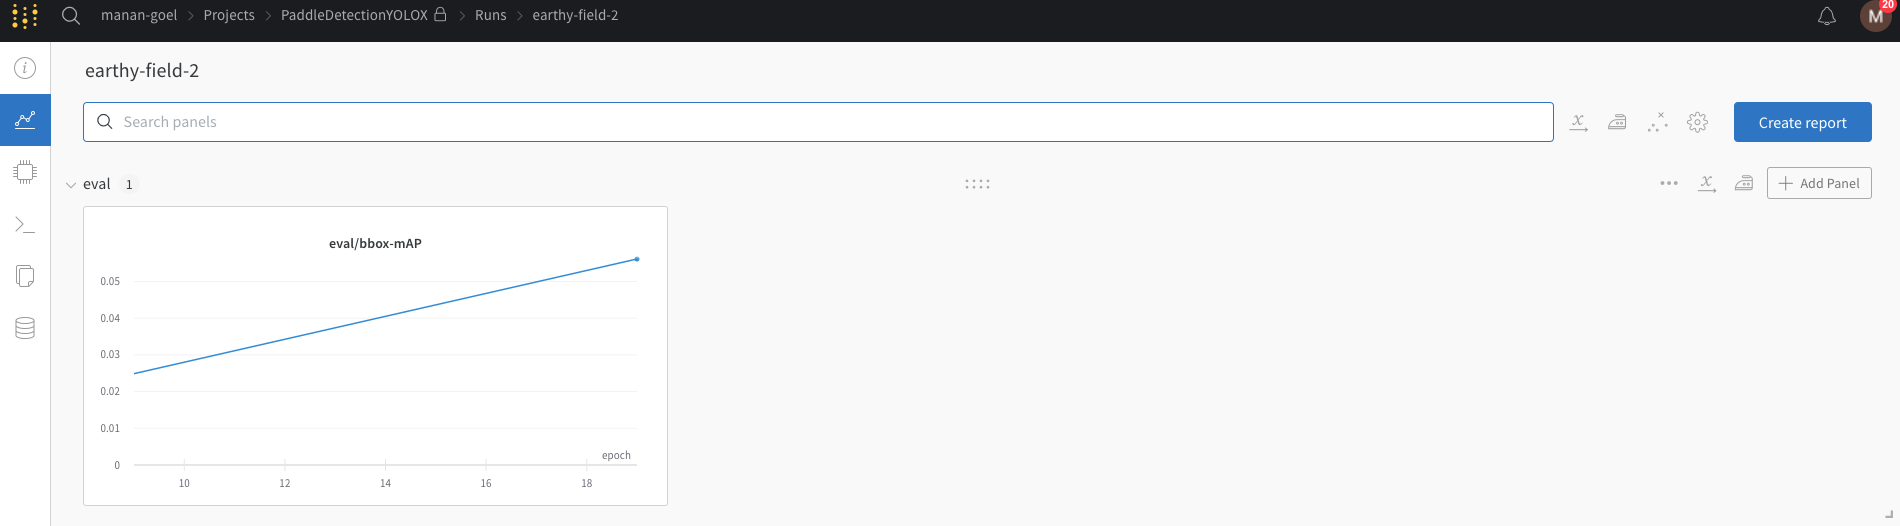

The model checkpoints are also logged at the end of every snapshot epoch along with the corresponding average precision.
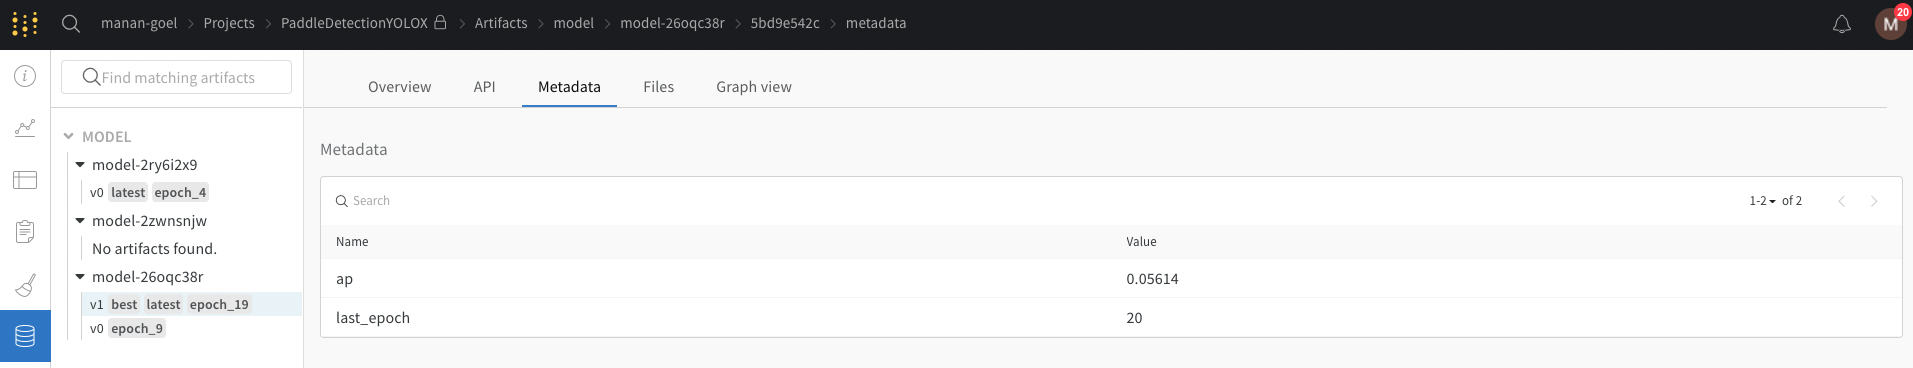

## Evaluation and Testing 🤔

### Download the Best Model from W&B 💾

To download the model with the best accuracy from W&B for evaluation you can use the following snippet

In [ ]:
artifact = wandb.Api().artifact('manan-goel/PaddleDetectionYOLOX/model-26oqc38r:best', type='model')
artifact_dir = artifact.download()
os.rename(artifact_dir + "/model", artifact_dir + "/model.pdparams")
artifact_dir

### Testing and Logging annotated images to your W&B dashboard 🔥

The following cell runs the inference script on all the images in `demo` directory and stores the annotated images with the bounding boxes in the `infer_output` directory using the YOLOX model pulled from W&B.

In [ ]:
%%shell
for i in $(ls demo/*.jpg)
do
    python tools/infer.py -c configs/yolox/yolox_nano_300e_coco.yml \
                    --infer_img=$i \
                    --output_dir=infer_output/ \
                    --draw_threshold=0.5 \
                    -o weights=./artifacts/model-26oqc38r:v1/model
done

With the images being annotated, we will now initialize a new run in the project and a W&B table which we will then use to add the input and output images side-by-side.

In [ ]:
wandb.init(project="PaddleDetectionYOLOX")
wandb.use_artifact('manan-goel/PaddleDetectionYOLOX/model-26oqc38r:best')
table = wandb.Table(columns=["Input Image", "Annotated Image"])

inp_imgs = sorted(glob.glob("./demo/*.jpg"), key=lambda x: x.split("/")[-1])
out_imgs = sorted(glob.glob("./infer_output/*.jpg"), key=lambda x: x.split("/")[-1])

The next cell iterates over the images and adds the corresponding inputs and outputs as a row in the table initialized in the previous cell.

In [ ]:
for inp in inp_imgs:
    for out in out_imgs:
        if out.split("/")[-1] != inp.split("/")[-1]:
            continue
        table.add_data(
            wandb.Image(inp),
            wandb.Image(out)
        )
wandb.log({
    "Predictions": table
})
wandb.finish()

This provides a really cool debugging tool!
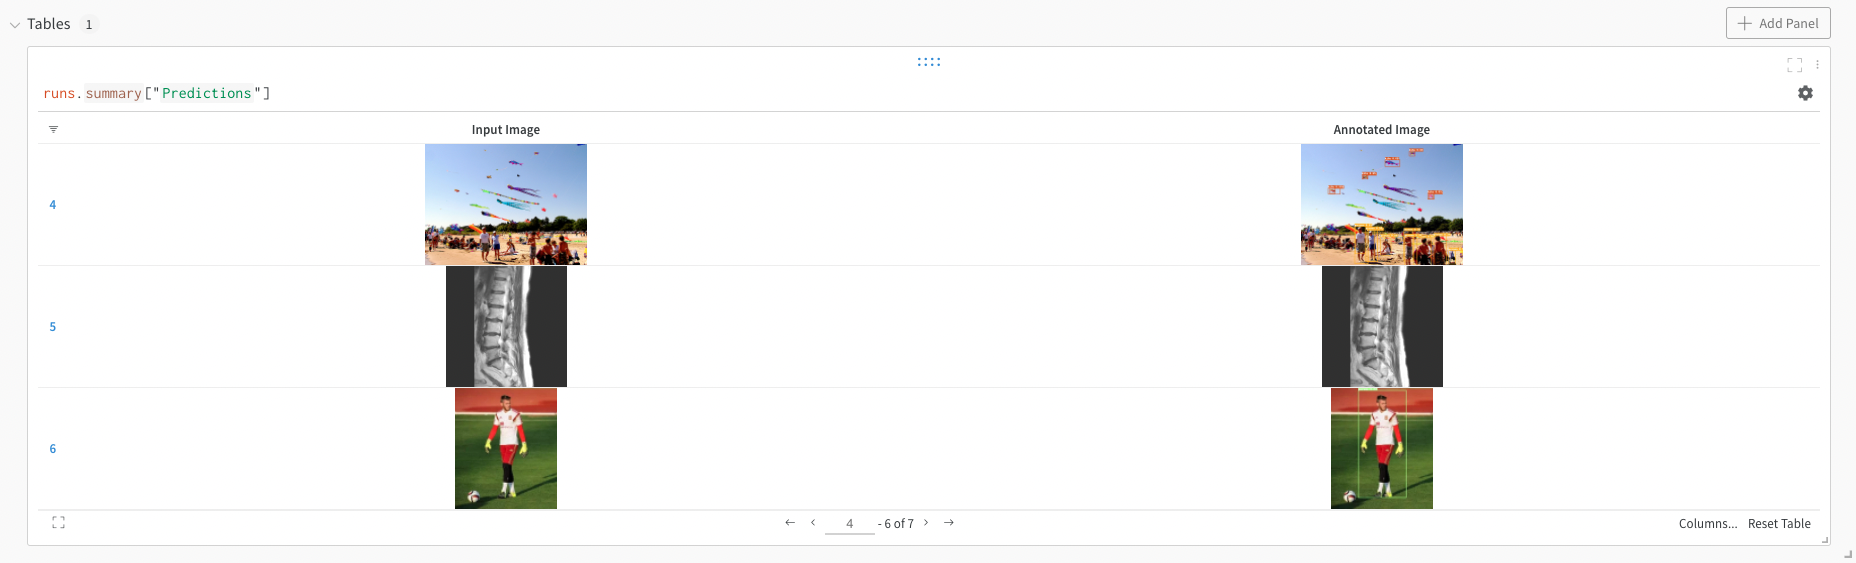

## Resources📕

*  [W&B and PaddleDetection Documentation](https://docs.wandb.ai/guides/integrations/other/paddledetection) contains a few tips for taking most advantage of W&B.
*  More PaddleDetection documentation is available [here](https://github.com/PaddlePaddle/PaddleDetection)


## Questions about W&B❓

If you have any questions about using W&B to track your model performance and predictions, please contact support@wandb.com